In [1]:

%pprint
import sys
if (osp.join(os.pardir, 'py') not in sys.path): sys.path.insert(1, osp.join(os.pardir, 'py'))

Pretty printing has been turned OFF


In [2]:

from FRVRS import (nu, fu, osp, re, DataFrame, np, display, walk, Series)
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


# Analyze Util Function Usage Frequency

In [3]:

nu.delete_ipynb_checkpoint_folders()


## Create a within-function function-call node-and-edge network visualization

In [4]:

defs_regex = re.compile(r'^    def ([a-z]+[a-z_]+)\([^\)]+\):\s+"""[^"]+"""', re.MULTILINE)
with open('../py/FRVRS/frvrs_utils.py', 'r', encoding=nu.encoding_type) as f:
    text = f.read()
    defs_list = defs_regex.split(text)

In [17]:

# Create a regular expression of both kinds of utils function calls
all_calls_regex = re.compile(r'(self|nu)\.([a-z]+[a-z0-9_]+)')
functions_list = [
    'get_percent_hemorrhage_controlled', 'get_time_to_last_hemorrhage_controlled', 'get_is_patient_hemorrhaging',
    'get_time_to_hemorrhage_control',
    'get_is_injury_hemorrhage', 'get_is_hemorrhage_tool_applied', 'get_is_hemorrhage_controlled', 'get_is_injury_severe',
    'get_is_bleeding_correctly_treated'
]

# Create data structures to tally the nodes, edges, and weights
nodes_set = set()
edge_tuple_dict = {}
for i in range(1, len(defs_list), 2):
    fn_name = defs_list[i]
    if fn_name in functions_list:
        fn_body = defs_list[i+1]
        # print(fn_name)
        # print(fn_body)
        calls_list = all_calls_regex.findall(fn_body)
        if calls_list:
            nodes_set.add('fu.' + fn_name)
            for called in calls_list:
                called = '.'.join(called).replace('self.', 'fu.')
                nodes_set.add(called)
                edge_tuple = (called, 'fu.' + fn_name)
                edge_tuple_dict[edge_tuple] = edge_tuple_dict.get(edge_tuple, 0) + 1

# Create the directed graph
dg = nx.DiGraph()
dg.add_nodes_from(nodes_set)
dg.add_weighted_edges_from([(k[0], k[1], v) for k, v in edge_tuple_dict.items()])

In [19]:

communities_generator = nx.community.girvan_newman(dg)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)
communities_list = sorted(map(sorted, next_level_communities), key=lambda x: len(x), reverse=True)

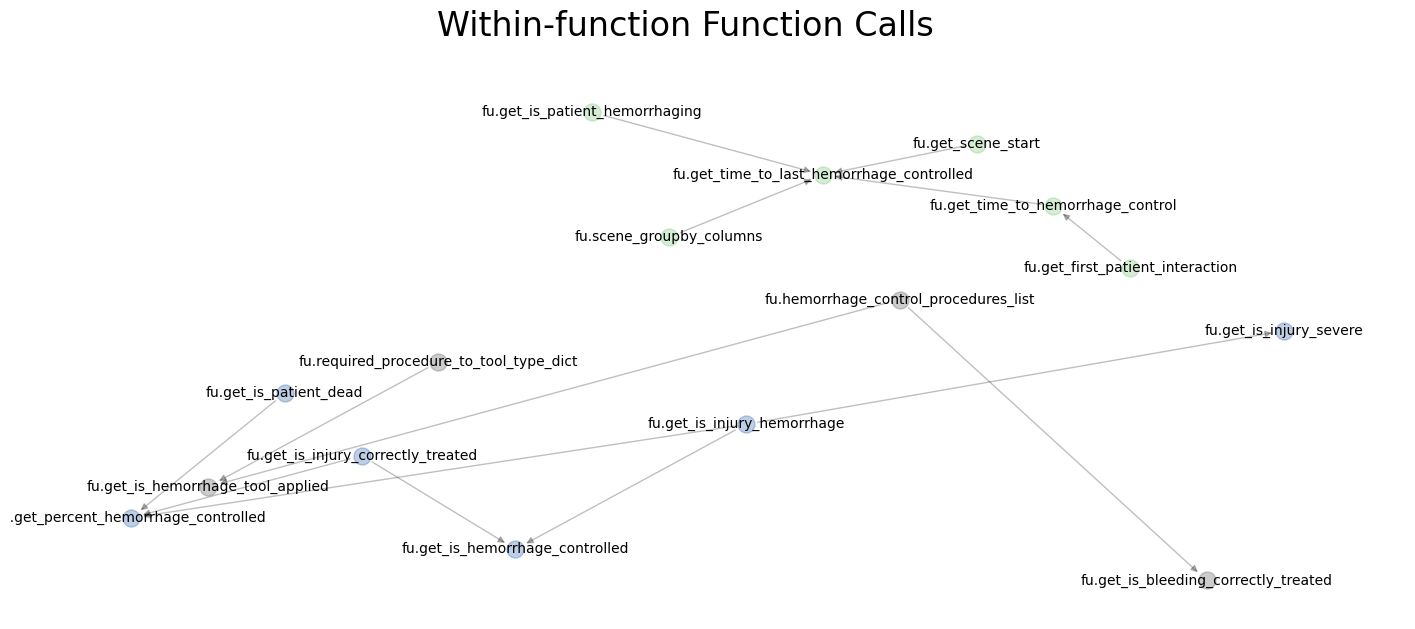

In [20]:

nu.show_subgraph(nx.subgraph(dg, {node for nodes_list in communities_list[0:7] for node in nodes_list}), nodes_list_list=communities_list[0:7], verbose=False)

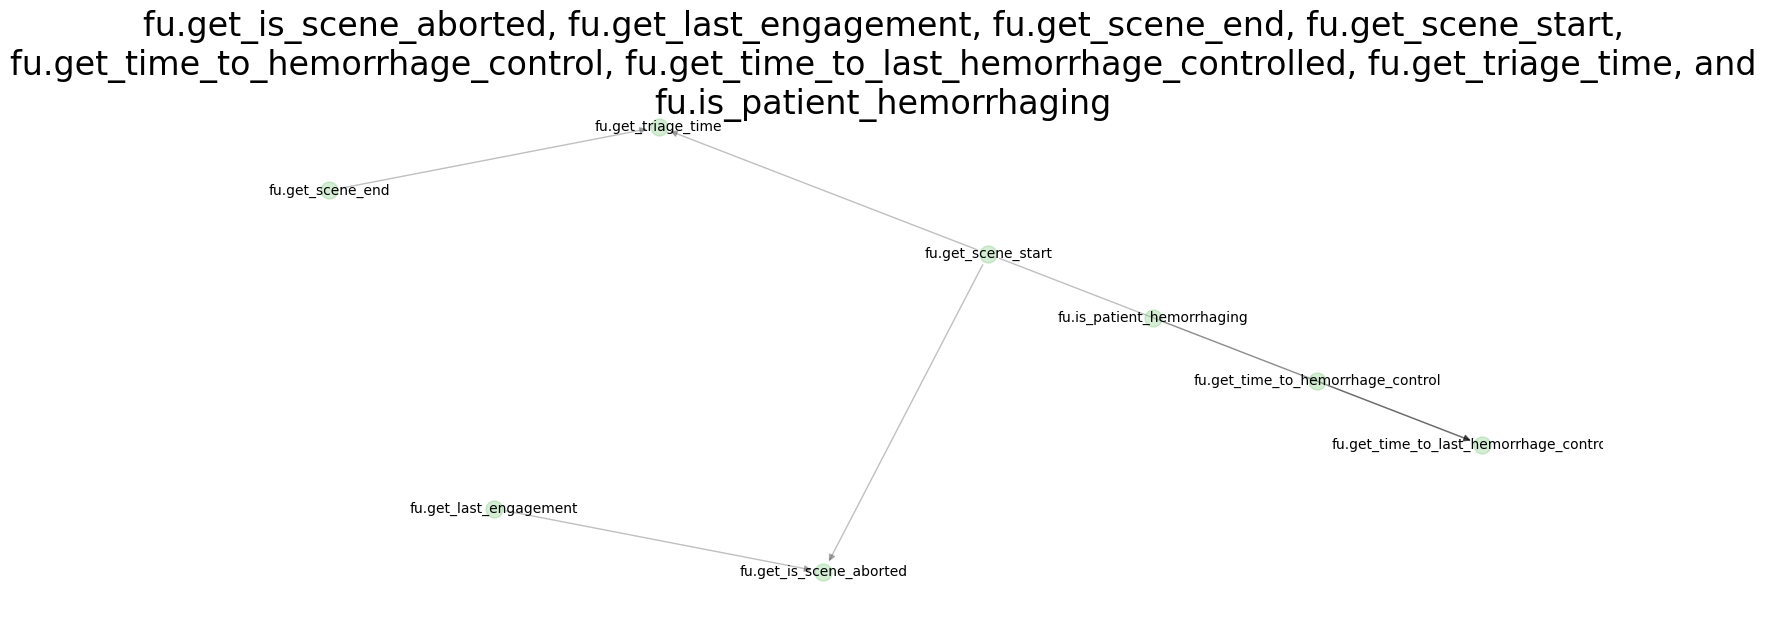

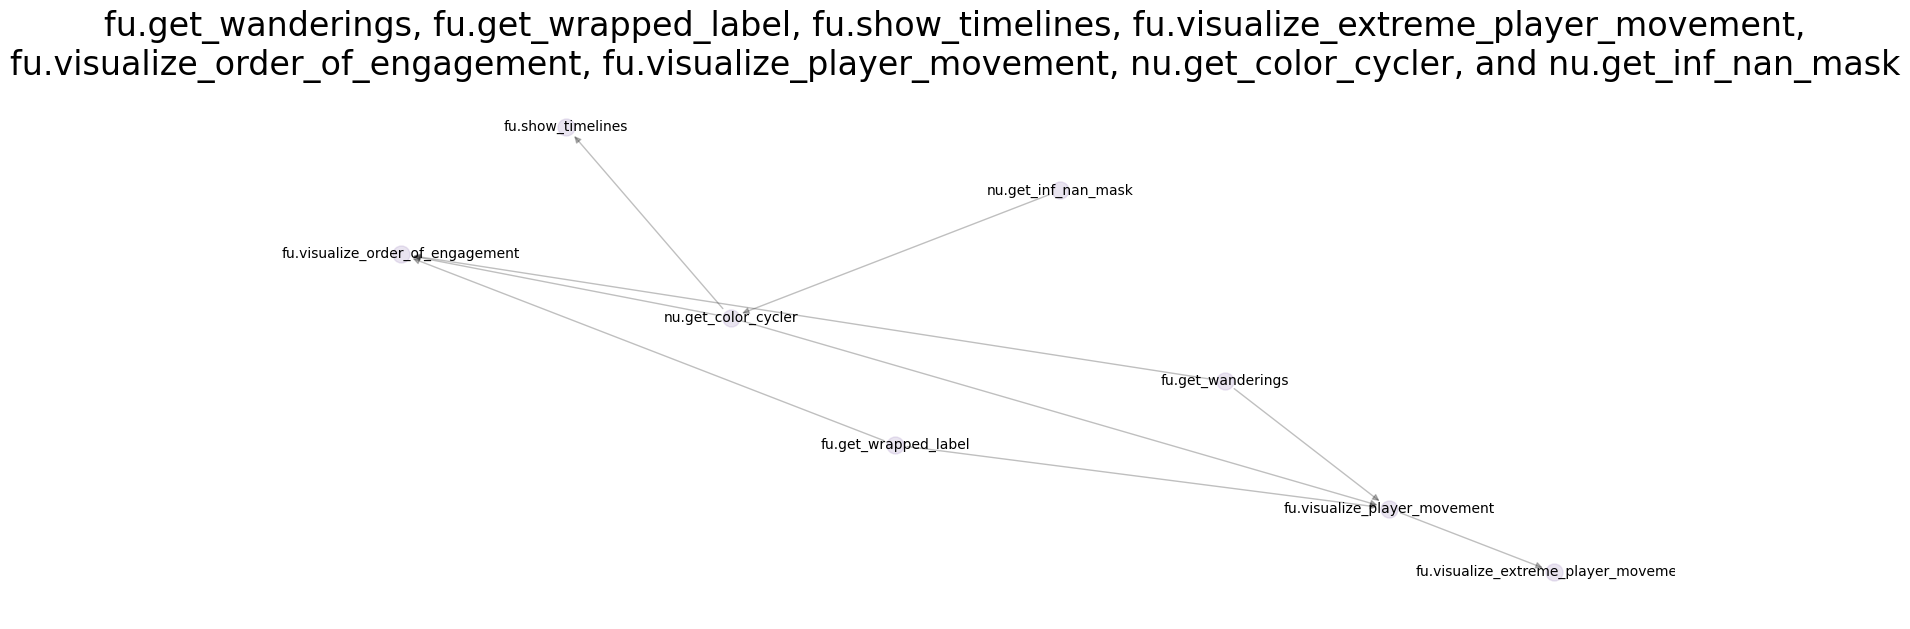

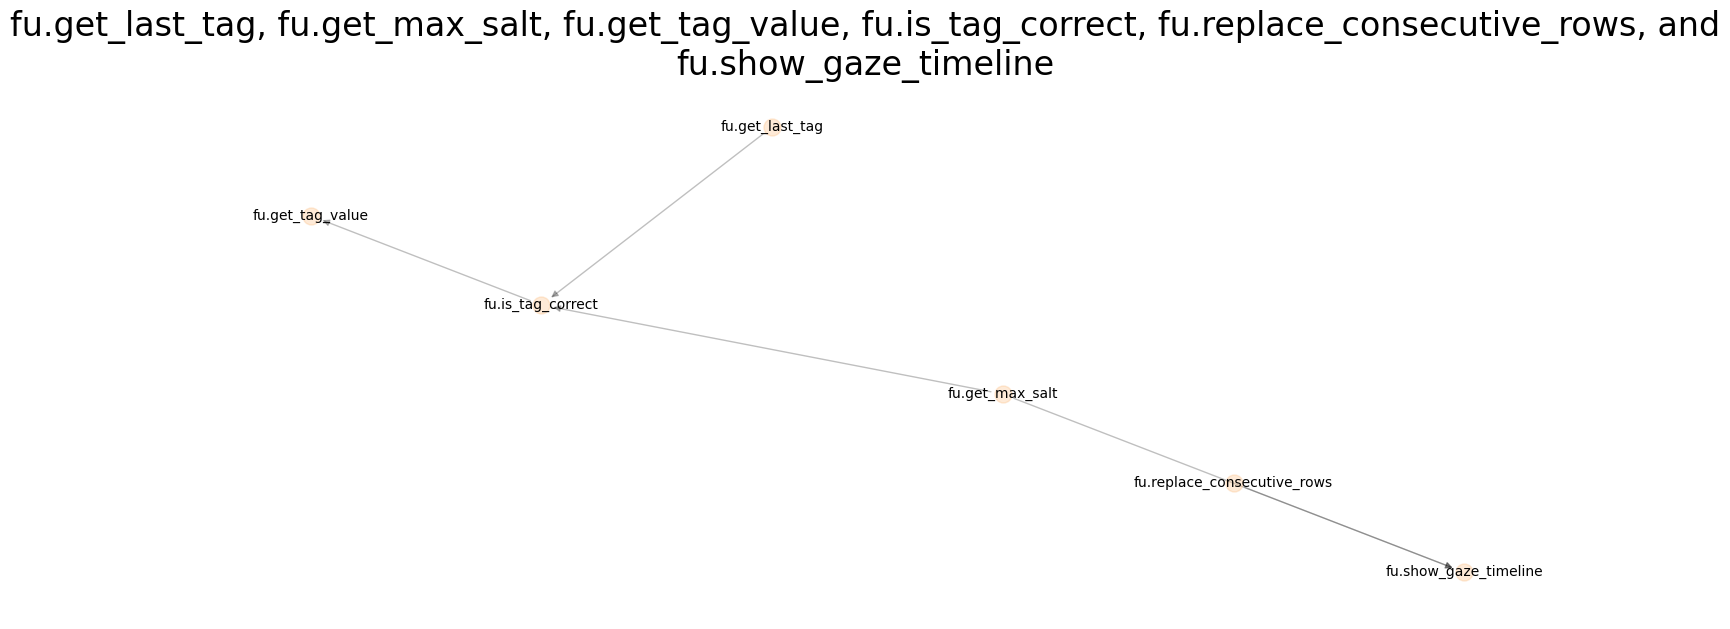

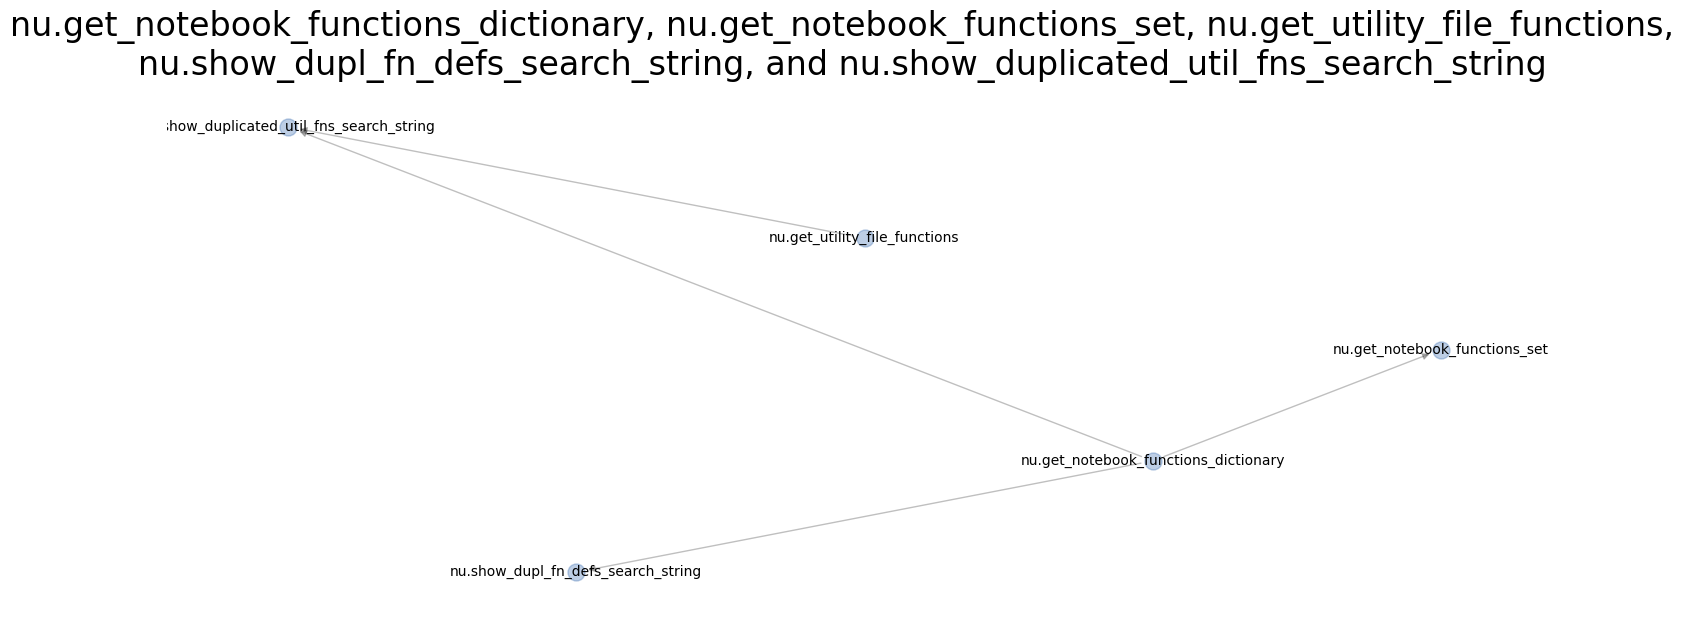

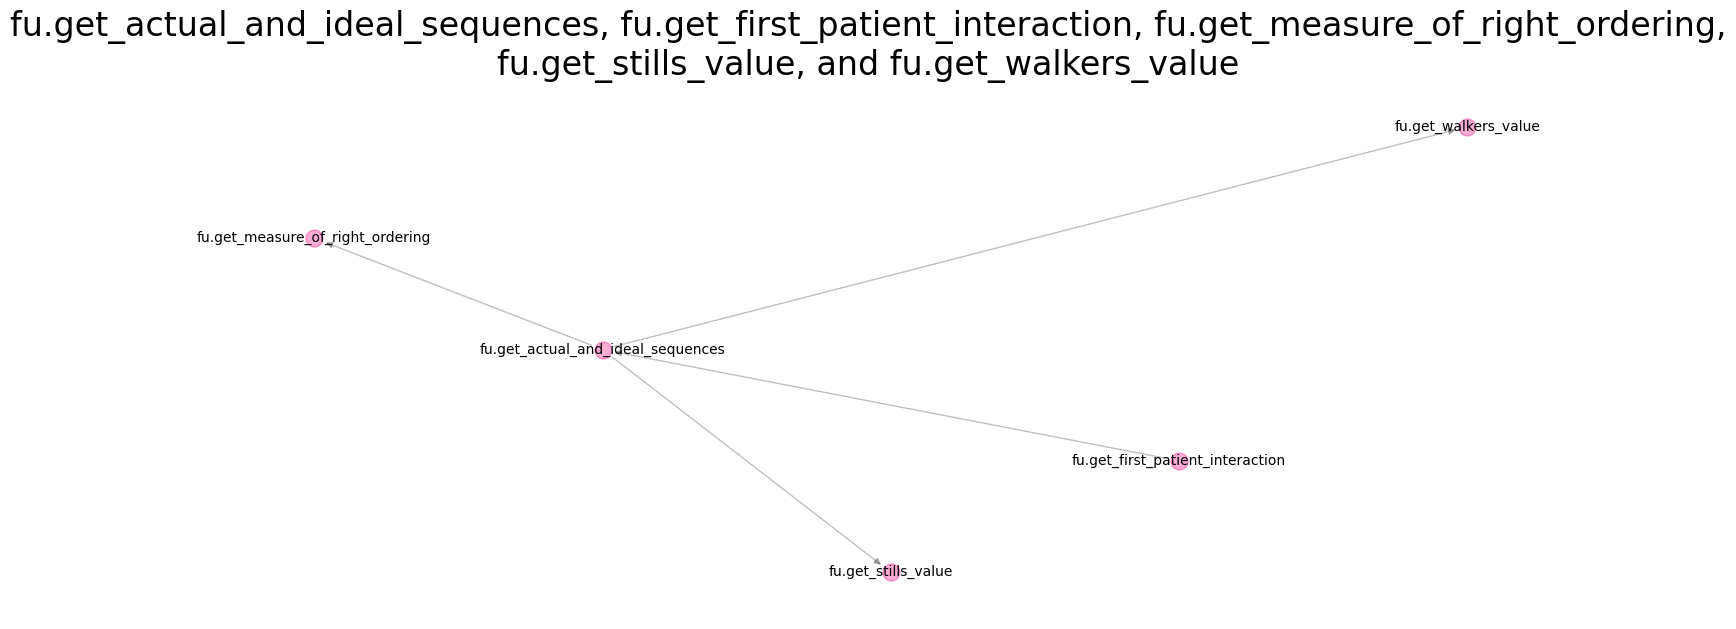

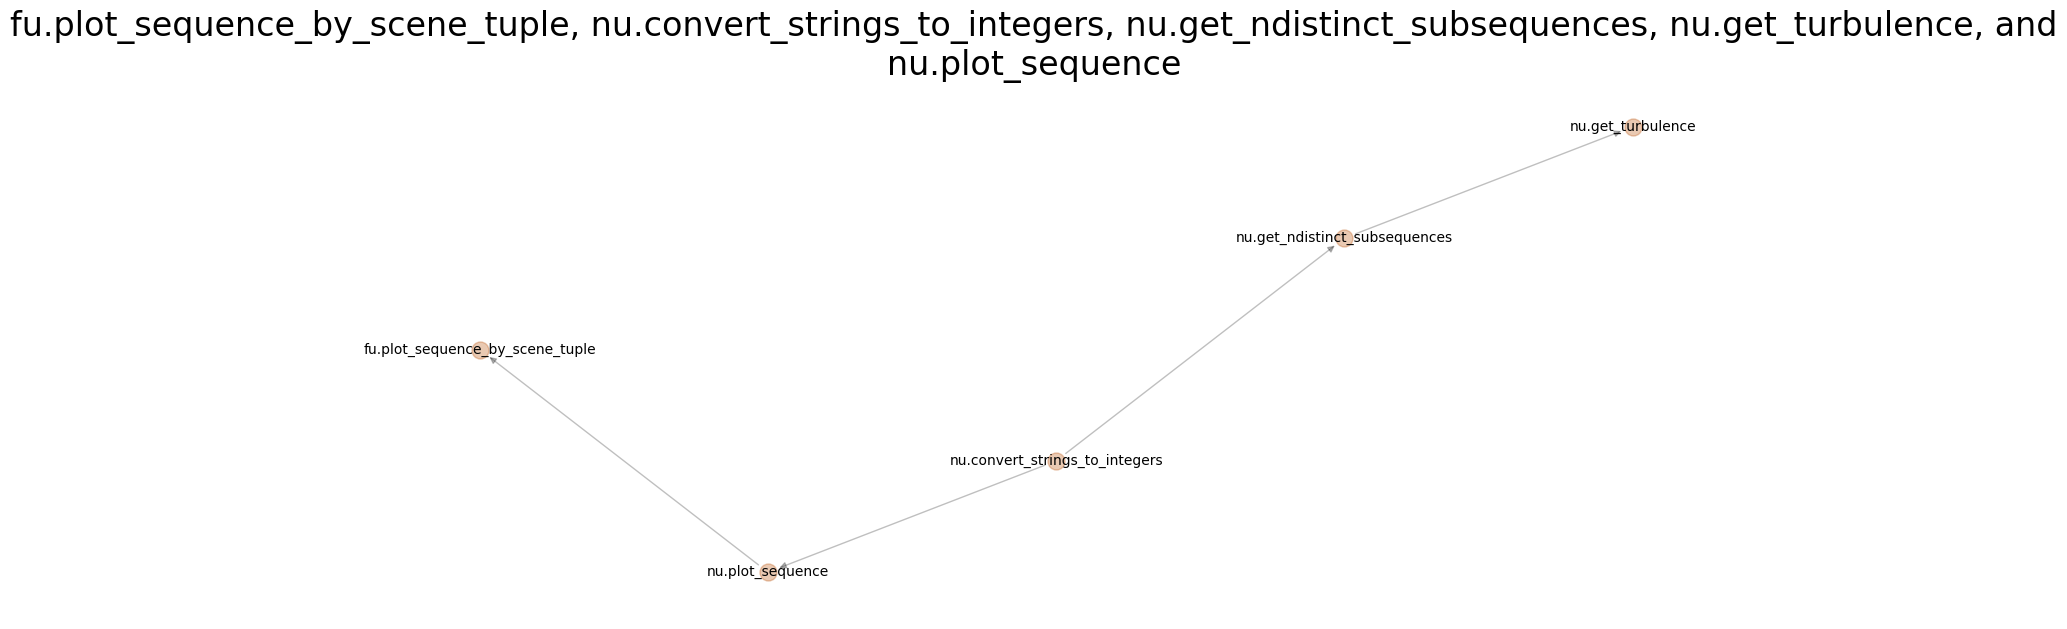

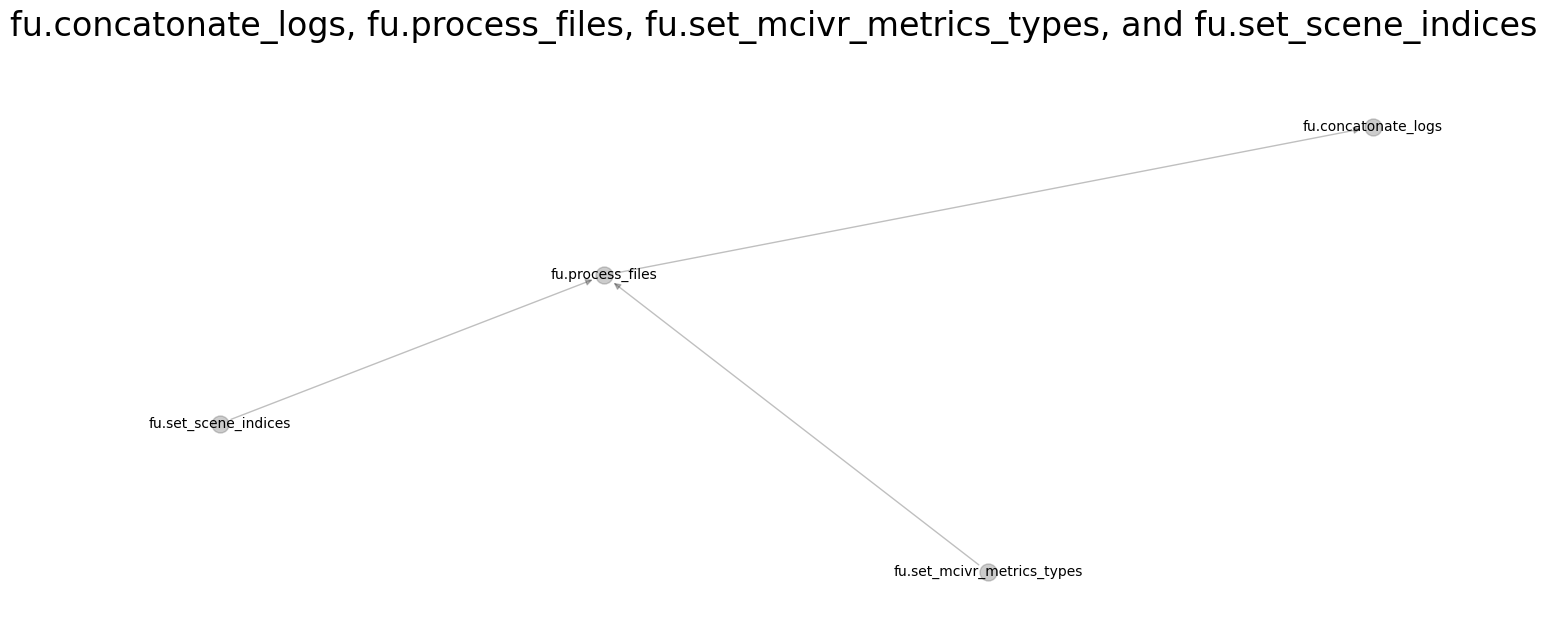

In [42]:

# Wrap the label to a specified width
import textwrap
from numpy import array

colors_list = [
    array([0.49803922, 0.78823529, 0.49803922, 1.0]), array([0.74509804, 0.68235294, 0.83137255, 1.0]), array([0.99215686, 0.75294118, 0.5254902 , 1.0]),
    array([0.21960784, 0.42352941, 0.69019608, 1.0]), array([0.94117647, 0.00784314, 0.49803922, 1.0]), array([0.74901961, 0.35686275, 0.09019608, 1.0]),
    array([0.4, 0.4, 0.4, 1.0])
]
for nodes_list, node_color in zip(communities_list[0:7], colors_list):
    sub_graph = nx.subgraph(dg, nodes_list)
    suptitle = '\n'.join(textwrap.wrap(nu.conjunctify_nouns(nodes_list), width=120))
    nu.show_subgraph(sub_graph, suptitle=suptitle, node_color=node_color)

In [67]:

[f'mpatches.ArrowStyle.{fn}' for fn in dir(mpatches.ArrowStyle) if not fn.startswith('_')]

['mpatches.ArrowStyle.BarAB', 'mpatches.ArrowStyle.BracketA', 'mpatches.ArrowStyle.BracketAB', 'mpatches.ArrowStyle.BracketB', 'mpatches.ArrowStyle.BracketCurve', 'mpatches.ArrowStyle.Curve', 'mpatches.ArrowStyle.CurveA', 'mpatches.ArrowStyle.CurveAB', 'mpatches.ArrowStyle.CurveB', 'mpatches.ArrowStyle.CurveBracket', 'mpatches.ArrowStyle.CurveFilledA', 'mpatches.ArrowStyle.CurveFilledAB', 'mpatches.ArrowStyle.CurveFilledB', 'mpatches.ArrowStyle.Fancy', 'mpatches.ArrowStyle.Simple', 'mpatches.ArrowStyle.Wedge', 'mpatches.ArrowStyle.get_styles', 'mpatches.ArrowStyle.pprint_styles', 'mpatches.ArrowStyle.register']

In [66]:

print(mpatches.ArrowStyle.pprint_styles())


    =============  ==========  ===============================================================================================================================
    Class          Name        Attrs                                                                                                                          
    =============  ==========  ===============================================================================================================================
    Curve          ``-``       None                                                                                                                           
    CurveA         ``<-``      head_length=0.4, head_width=0.2, widthA=1.0, widthB=1.0, lengthA=0.2, lengthB=0.2, angleA=0, angleB=0, scaleA=None, scaleB=None
    CurveB         ``->``      head_length=0.4, head_width=0.2, widthA=1.0, widthB=1.0, lengthA=0.2, lengthB=0.2, angleA=0, angleB=0, scaleA=None, scaleB=None
    CurveAB        ``<->``     head_length=0.


## List out various function calls

In [22]:

# Create a regular expression of all the non-staticmethod-decorated utils functions
instance_defs_regex = re.compile(r'^    def ([a-z]+[a-z_]+)\(\s*self,\s+(?:[^\)]+)\):', re.MULTILINE)
functions_list = []
for file_name in ['frvrs_utils.py', 'notebook_utils.py']:
    with open(f'../py/FRVRS/{file_name}', 'r', encoding=nu.encoding_type) as f: text = f.read()
    for match_obj in instance_defs_regex.finditer(text):
        functions_list.append(''.join([s[0] for s in file_name.split('.')[0].split('_')]) + '\\.' + match_obj.group(1))

instance_functions_regex = re.compile('\\b(' + '|'.join(functions_list) + ')\\b')

In [9]:

# Tabulate util function usage frequency
usage_frequency_dict = {}
all_calls_frequency_dict = {}
for sub_directory, directories_list, files_list in walk(nu.github_folder):
    if '.ipynb_checkpoints' not in sub_directory:
        for file_name in files_list:
            if file_name.endswith('.ipynb') and not ('Attic' in file_name):
                file_path = osp.join(sub_directory, file_name)
                with open(file_path, 'r', encoding=nu.encoding_type) as f:
                    lines_list = f.readlines()
                    for line in lines_list:
                        match_obj = instance_functions_regex.search(line)
                        if match_obj:
                            fn = match_obj.group(1)
                            usage_frequency_dict[fn] = usage_frequency_dict.get(fn, 0) + 1
                        match_obj = all_calls_regex.search(line)
                        if match_obj:
                            fn = match_obj.group()
                            all_calls_frequency_dict[fn] = all_calls_frequency_dict.get(fn, 0) + 1

In [10]:

usage_frequency_df = Series(usage_frequency_dict).to_frame().reset_index().rename(columns={0: 'usage_frequency', 'index': 'function_call'})
usage_frequency_df.sort_values('usage_frequency', ascending=False).head(20)

,function_call,usage_frequency
11,fu.visualize_extreme_player_movement,36
4,fu.get_is_scene_aborted,25
5,nu.save_data_frames,20
13,"fig, ax = nu.plot_sequence",17
25,fu.visualize_player_movement,15
12,fu.get_first_patient_interaction,14
26,fu.show_time_statistics,12
27,"fig, ax = fu.plot_sequence_by_scene_tuple",10
17,nu.load_data_frames,9
21,nu.check_for_typos,8


In [11]:

all_calls_frequency_df = Series(all_calls_frequency_dict).to_frame().reset_index().rename(
    columns={0: 'all_calls_frequency', 'index': 'function_call'}
)
all_calls_frequency_df.sort_values('all_calls_frequency', ascending=False).head(20)

,function_call,all_calls_frequency
14,fu.scene_groupby_columns,106
0,nu.pickle_exists,101
1,nu.load_object,101
3,nu.store_objects,85
2,fu.patient_groupby_columns,57
5,fu.get_session_groupby,39
44,fu.visualize_extreme_player_movement,36
20,nu.conjunctify_nouns,32
23,fu.get_logger_version,30
56,nu.get_sequences_by_count,27


In [ ]:

mask_series = (usage_frequency_df.usage_frequency == 1)
usage_frequency_df[mask_series]